In [1]:
#import packages
import pandas as pd
import numpy as np
import glob,os
import matplotlib.dates as mdates

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

#to set seed
np.random.seed(0) # for reproducibility
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries for Forecasting 
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM

from pmdarima.arima import auto_arima
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#for cointegration test 
from statsmodels.tsa.stattools import coint
import scipy

#read the file
import pandas_datareader as pdr
from datetime import datetime, timedelta
import statsmodels.regression.linear_model as rg
import arch.unitroot as at

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r'./data/data_all.csv',index_col=0)
print(data.shape)

(21894, 21)


In [3]:
data.index = pd.to_datetime(data.index, unit='ms')
data = data[~data.index.duplicated(keep='first')]
print(data.shape)
data = data.resample('60T').pad()
data.head()

(21894, 21)


ADAUSDT  BATUSDT  BTCUSDT   BTTUSDT  DASHUSDT  EOSUSDT  \
Time                                                                          
2019-06-01 00:00:00  0.09022   0.3506  8585.99  0.001578    166.91   8.5587   
2019-06-01 01:00:00  0.08945   0.3480  8567.58  0.001594    165.82   8.5188   
2019-06-01 02:00:00  0.09004   0.3487  8555.00  0.001633    165.67   8.4997   
2019-06-01 03:00:00  0.08960   0.3491  8552.75  0.001605    166.11   8.4419   
2019-06-01 04:00:00  0.08950   0.3493  8561.23  0.001643    165.16   8.5013   

                     ETCUSDT  ETHUSDT   HOTUSDT  IOTAUSDT  ...  LTCUSDT  \
Time                                                       ...            
2019-06-01 00:00:00   8.7086   274.72  0.002300    0.5132  ...   116.12   
2019-06-01 01:00:00   8.6676   272.24  0.002306    0.5111  ...   115.14   
2019-06-01 02:00:00   8.7712   271.06  0.002287    0.5109  ...   114.96   
2019-06-01 03:00:00   8.8010   269.70  0.002278    0.5085  ...   114.49   
2019-06-01 04:00:00   8.7862   270.58  0.002323    0.5056  ...   114.83   

                     NEOUSDT  OMGUSDT  QTUMUSDT  THETAUSDT  TRXUSDT   VETUSDT  \
Time                                                                            
2019-06-01 00:00:00   13.755   2.2957     3.491    0.13546  0.03335  0.007719   
2019-06-01 01:00:00   13.674   2.2876     3.516    0.13394  0.03331  0.007767   
2019-06-01 02:00:00   14.277   2.3371     3.700    0.13506  0.03407  0.007701   
2019-06-01 03:00:00   13.985   2.3156     3.682    0.13360  0.03370  0.007707   
2019-06-01 04:00:00   13.983   2.3150     3.676    0.13402  0.03378  0.007600   

                     XLMUSDT  XMRUSDT  XRPUSDT  
Time                                            
2019-06-01 00:00:00  0.13455    93.83  0.44145  
2019-06-01 01:00:00  0.13355    93.48  0.43855  
2019-06-01 02:00:00  0.13389    93.36  0.43840  
2019-06-01 03:00:00  0.13292    93.11  0.43638  
2019-06-01 04:00:00  0.13329    93.07  0.43905  

[5 rows x 21 columns]

In [8]:
def plot_return(dt, title):
    fig = plt.figure(figsize = (16,8))
    plt.rcParams.update({'font.size':10})
    plt.xticks(rotation=45)
    plt.plot(dt)
    plt.xlabel("Date")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.grid(True)
    plt.legend(dt.columns.to_list(), loc='best')
    plt.show()

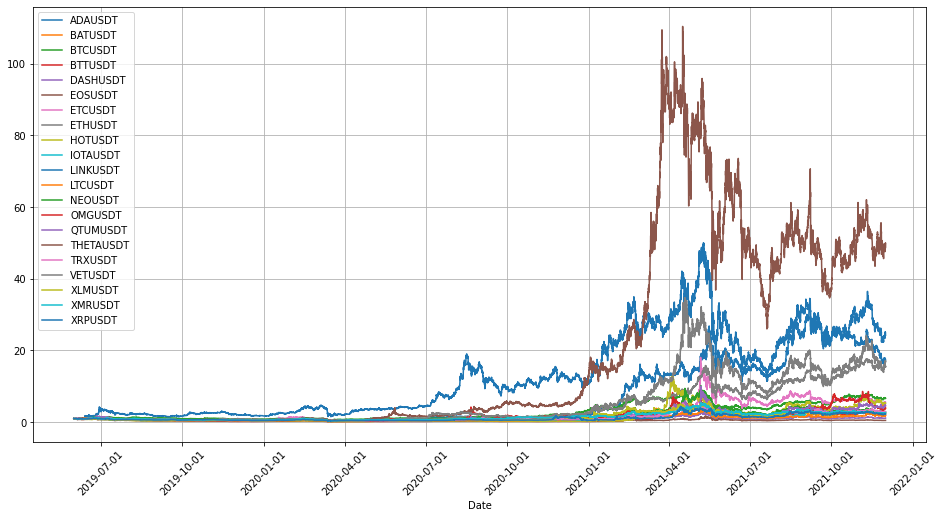

In [9]:
# Normalize prices by first value
assets = data.columns.to_list()
norm_prices = data.divide(data.iloc[0])
plot_return(norm_prices, 'Performance of cryptocurrencies')

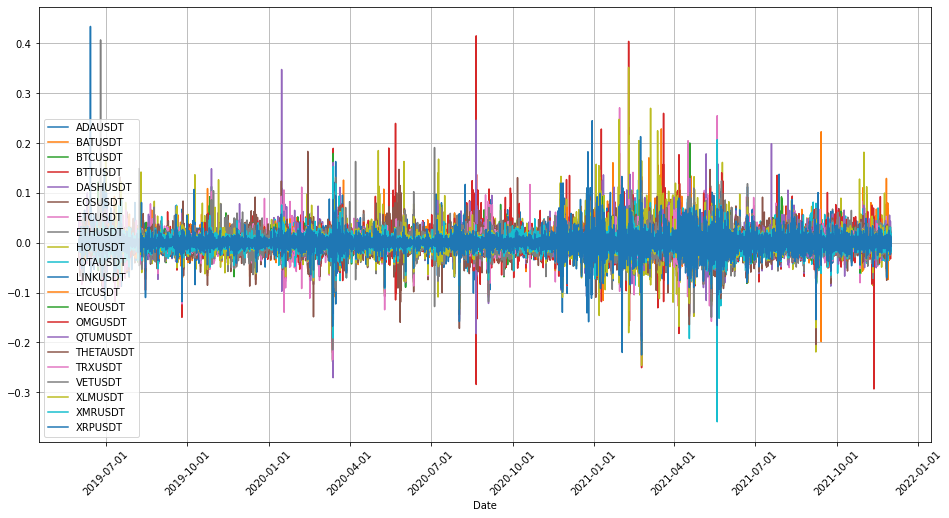

ADAUSDT   BATUSDT   BTCUSDT   BTTUSDT  DASHUSDT  \
Time                                                                    
2019-06-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2019-06-01 01:00:00 -0.008571 -0.007443 -0.002146  0.010277 -0.006552   
2019-06-01 02:00:00  0.006574  0.002009 -0.001469  0.024168 -0.000905   
2019-06-01 03:00:00 -0.004899  0.001146 -0.000263 -0.017230  0.002652   
2019-06-01 04:00:00 -0.001117  0.000573  0.000991  0.023273 -0.005736   

                      EOSUSDT   ETCUSDT   ETHUSDT   HOTUSDT  IOTAUSDT  ...  \
Time                                                                   ...   
2019-06-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2019-06-01 01:00:00 -0.004673 -0.004719 -0.009068  0.002605 -0.004100  ...   
2019-06-01 02:00:00 -0.002245  0.011882 -0.004344 -0.008317 -0.000391  ...   
2019-06-01 03:00:00 -0.006823  0.003392 -0.005030 -0.004031 -0.004709  ...   
2019-06-01 04:00:00  0.007012 -0.001683  0.003258  0.019693 -0.005719  ...   

                      LTCUSDT   NEOUSDT   OMGUSDT  QTUMUSDT  THETAUSDT  \
Time                                                                     
2019-06-01 00:00:00  0.000000  0.000000  0.000000  0.000000   0.000000   
2019-06-01 01:00:00 -0.008475 -0.005906 -0.003535  0.007136  -0.011284   
2019-06-01 02:00:00 -0.001565  0.043154  0.021408  0.051009   0.008327   
2019-06-01 03:00:00 -0.004097 -0.020665 -0.009242 -0.004877  -0.010869   
2019-06-01 04:00:00  0.002965 -0.000143 -0.000259 -0.001631   0.003139   

                      TRXUSDT   VETUSDT   XLMUSDT   XMRUSDT   XRPUSDT  
Time                                                                   
2019-06-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000  
2019-06-01 01:00:00 -0.001200  0.006199 -0.007460 -0.003737 -0.006591  
2019-06-01 02:00:00  0.022560 -0.008534  0.002543 -0.001285 -0.000342  
2019-06-01 03:00:00 -0.010919  0.000779 -0.007271 -0.002681 -0.004618  
2019-06-01 04:00:00  0.002371 -0.013981  0.002780 -0.000430  0.006100  

[5 rows x 21 columns]

In [10]:
def cal_return(data):
    '''calculate log return'''
    dr = data.apply(lambda x: np.log(x/x.shift(1)).fillna(0))
    return dr

dr = cal_return(data)
plot_return(dr, "Percentage changes")
dr.head()

In [11]:
# Trading period partition

train_periods = []
test_periods = []
year = 2019
month = 6 #2019-06-01
for i in range(6):
    print(i)
    train_periods.append((datetime(year,month,1), datetime(year+1,month,1)-timedelta(hours=-1)))
    y = (month+3)//12 if (month+3)!= 12 else 0
    m = (month+3)%12 if (month+3)!= 12 else 12
    test_periods.append((datetime(year+1,month,1), datetime(year+y+1,m,1)))
    year = year+y
    month = m

0
1
2
3
4
5


In [12]:
print(train_periods)
print("------------------------------")
print(test_periods)

[(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2020, 6, 1, 1, 0)), (datetime.datetime(2019, 9, 1, 0, 0), datetime.datetime(2020, 9, 1, 1, 0)), (datetime.datetime(2019, 12, 1, 0, 0), datetime.datetime(2020, 12, 1, 1, 0)), (datetime.datetime(2020, 3, 1, 0, 0), datetime.datetime(2021, 3, 1, 1, 0)), (datetime.datetime(2020, 6, 1, 0, 0), datetime.datetime(2021, 6, 1, 1, 0)), (datetime.datetime(2020, 9, 1, 0, 0), datetime.datetime(2021, 9, 1, 1, 0))]
------------------------------
[(datetime.datetime(2020, 6, 1, 0, 0), datetime.datetime(2020, 9, 1, 0, 0)), (datetime.datetime(2020, 9, 1, 0, 0), datetime.datetime(2020, 12, 1, 0, 0)), (datetime.datetime(2020, 12, 1, 0, 0), datetime.datetime(2021, 3, 1, 0, 0)), (datetime.datetime(2021, 3, 1, 0, 0), datetime.datetime(2021, 6, 1, 0, 0)), (datetime.datetime(2021, 6, 1, 0, 0), datetime.datetime(2021, 9, 1, 0, 0)), (datetime.datetime(2021, 9, 1, 0, 0), datetime.datetime(2021, 12, 1, 0, 0))]


In [13]:
def coint_effect(data):
    
    """long-term cointegration test"""
    
    assets = data.columns.to_list()
    coint_mat = []
    for a1 in assets:
        coint_one = []
        for a2 in assets:
            test_result = ts.coint(data[a1], data[a2])
            coint_one.append(test_result[1])
        coint_mat.append(coint_one)
    coint_mat = pd.DataFrame(coint_mat, columns = assets, index=assets)
    
    return coint_mat

(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2020, 6, 1, 1, 0))


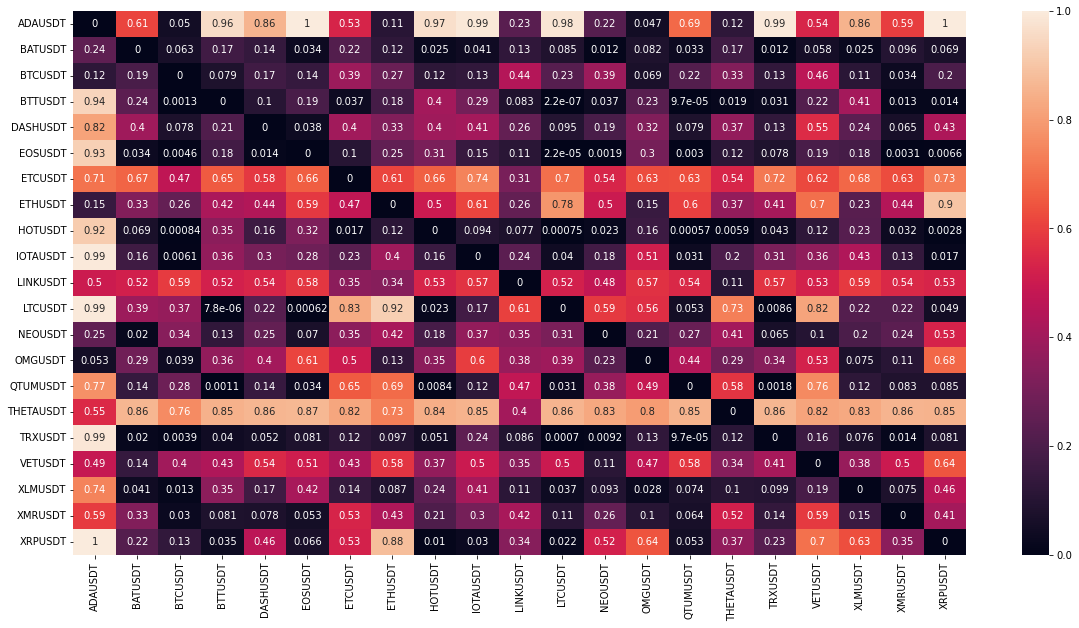

(datetime.datetime(2019, 9, 1, 0, 0), datetime.datetime(2020, 9, 1, 1, 0))


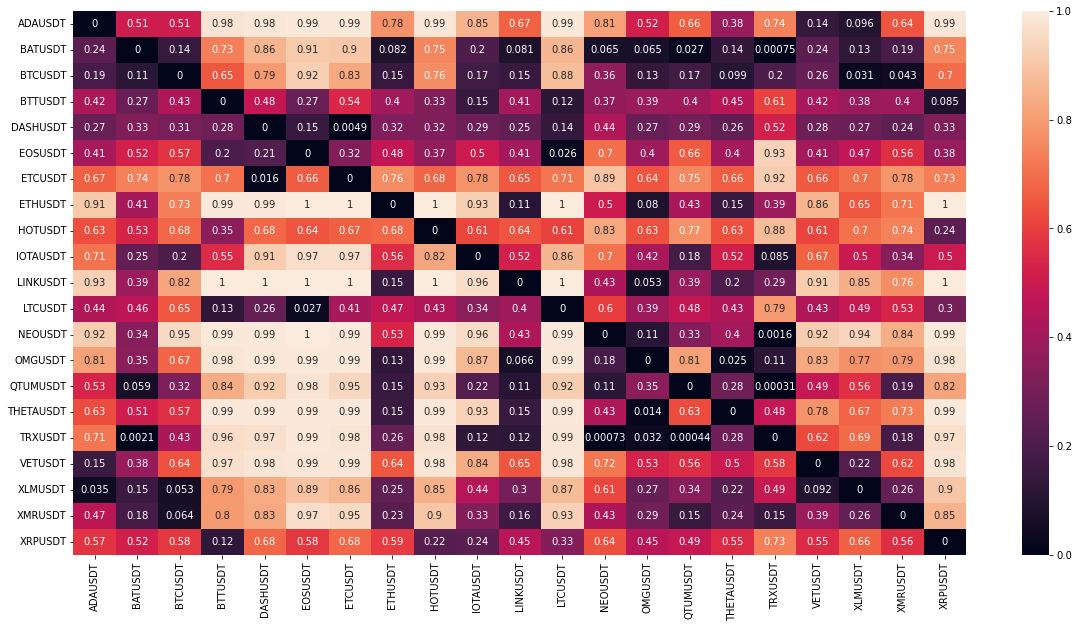

(datetime.datetime(2019, 12, 1, 0, 0), datetime.datetime(2020, 12, 1, 1, 0))


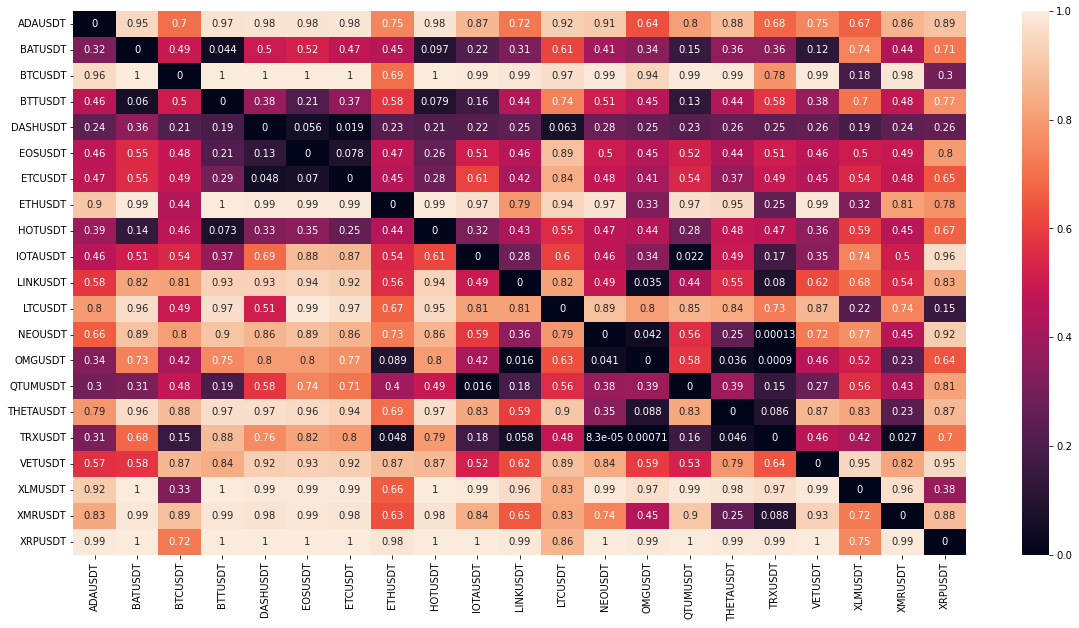

(datetime.datetime(2020, 3, 1, 0, 0), datetime.datetime(2021, 3, 1, 1, 0))


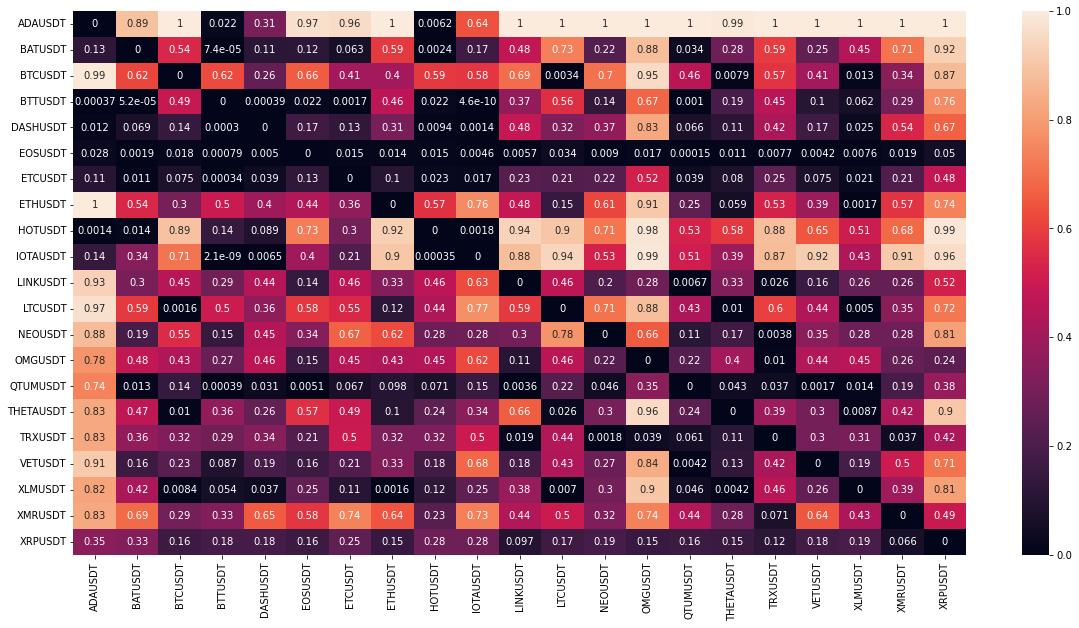

(datetime.datetime(2020, 6, 1, 0, 0), datetime.datetime(2021, 6, 1, 1, 0))


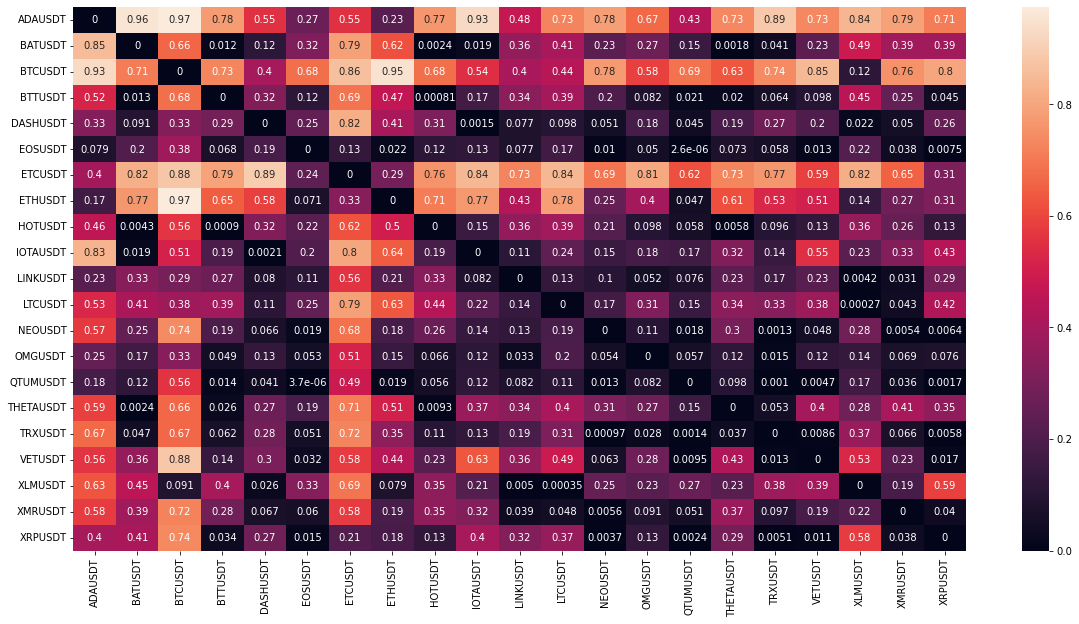

(datetime.datetime(2020, 9, 1, 0, 0), datetime.datetime(2021, 9, 1, 1, 0))


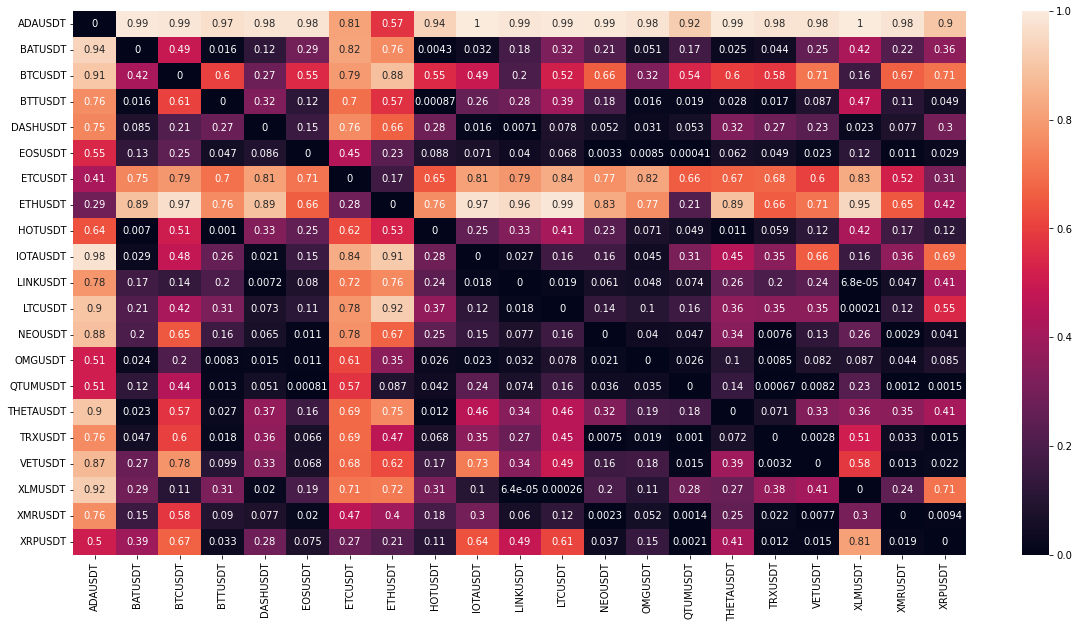

In [15]:
# Pick pairs (insample period)
n_pairs = 10

alpha = 0.01

dt_dict = {} # store all insample data and variables
for ix in range(len(train_periods)):
    print(train_periods[ix])
    dt_dict[ix] = {}
    dtr = train_periods[ix]
    dtrain = data.loc[dtr[0]:dtr[1]]
    drtrain = dr.loc[dtr[0]:dtr[1]]
    dts = test_periods[ix]
    dtest = data.loc[dts[0]:dts[1]]
    drtest = dr.loc[dts[0]:dts[1]]
    
    #first check ADF test
    
    #second calculate cointegration effect
    coints = coint_effect(dtrain)
    sn.heatmap(coints, annot=True)
    plt.show()
    assets = coints.columns.to_list()
    pairs = []
    for i in range(coints.shape[1]):
        for j in range(i+1, coints.shape[0]):
            if coints.iloc[i,j] < alpha:
                pairs.append((assets[i],assets[j]))
    
    # third rank pairwise correlation
    if len(pairs) <= 10:
        pairs2 = pairs
    else:
        corrs = pd.Series(index=range(len(pairs)))
        for i, pair in enumerate(pairs):
            corr = np.corrcoef(drtrain[pair[0]],drtrain[pair[1]])[1][0]
            corrs.iloc[i] = corr
        corrs = corrs.sort_values(ascending=False)
        pairs2 = [pairs[i] for i in list(corrs.index[:n_pairs])]
    
    l, s = zip(*pairs2)
    dtr_l = dtrain[list(l)]
    dtr_s = dtrain[list(s)]
    dts_l = dtest[list(l)]
    dts_s = dtest[list(s)]
    drtr_l = drtrain[list(l)]
    drtr_s = drtrain[list(s)]
    drts_l = drtest[list(l)]
    drts_s = drtest[list(s)]
    
    dt_dict[ix]['dtr_l'] = dtr_l
    dt_dict[ix]['dtr_s'] = dtr_s
    dt_dict[ix]['dts_l'] = dts_l
    dt_dict[ix]['dts_s'] = dts_s
    dt_dict[ix]['drtr_l'] = drtr_l
    dt_dict[ix]['drtr_s'] = drtr_s
    dt_dict[ix]['drts_l'] = drts_l
    dt_dict[ix]['drts_s'] = drts_s
    
    beta = rg.OLS(np.log(dtr_l), np.log(dtr_s)).fit().params[0] # coefficient of cointegration
    beta.index = pairs2
    dt_dict[ix]['beta'] = beta
    
    # train period spread
    pair_spreads = []
    for b in range(len(beta.index)):
        temp = dtr_l.iloc[:,b] - beta.iloc[b] * dtr_s.iloc[:,b]
        pair_spreads.append(temp)
    pair_spread = pd.concat(pair_spreads,axis=1)
    pair_spread.columns = pairs2
    dt_dict[ix]['train_spread'] = pair_spread
    
    #  test period spread
    pair_spreads = []
    for b in range(len(beta.index)):
        temp = dts_l.iloc[:,b] - beta.iloc[b] * dts_s.iloc[:,b]
        pair_spreads.append(temp)
    pair_spread = pd.concat(pair_spreads,axis=1)
    pair_spread.columns = pairs2
    dt_dict[ix]['test_spread'] = pair_spread
    
    

In [16]:
dt_dict.keys()


dict_keys([0, 1, 2, 3, 4, 5])

In [85]:
import pickle
# pickle.dump(dt_dict, open("./data/dt_dict_0.99.p",'wb'))
# dt_dict = pickle.load(open("./data/dt_dict_0.99.p",'rb'))
dt_dict = pickle.load(open("./data/dt_dict_0.95.p",'rb'))

In [86]:
# In sample
train_in = train_periods[:4]
test_in = test_periods[:4]

# OOS 
train_oos = train_periods[4:]
test_oos = test_periods[4:]

## Insample backtest

(datetime.datetime(2019, 6, 1, 0, 0), datetime.datetime(2020, 6, 1, 1, 0))


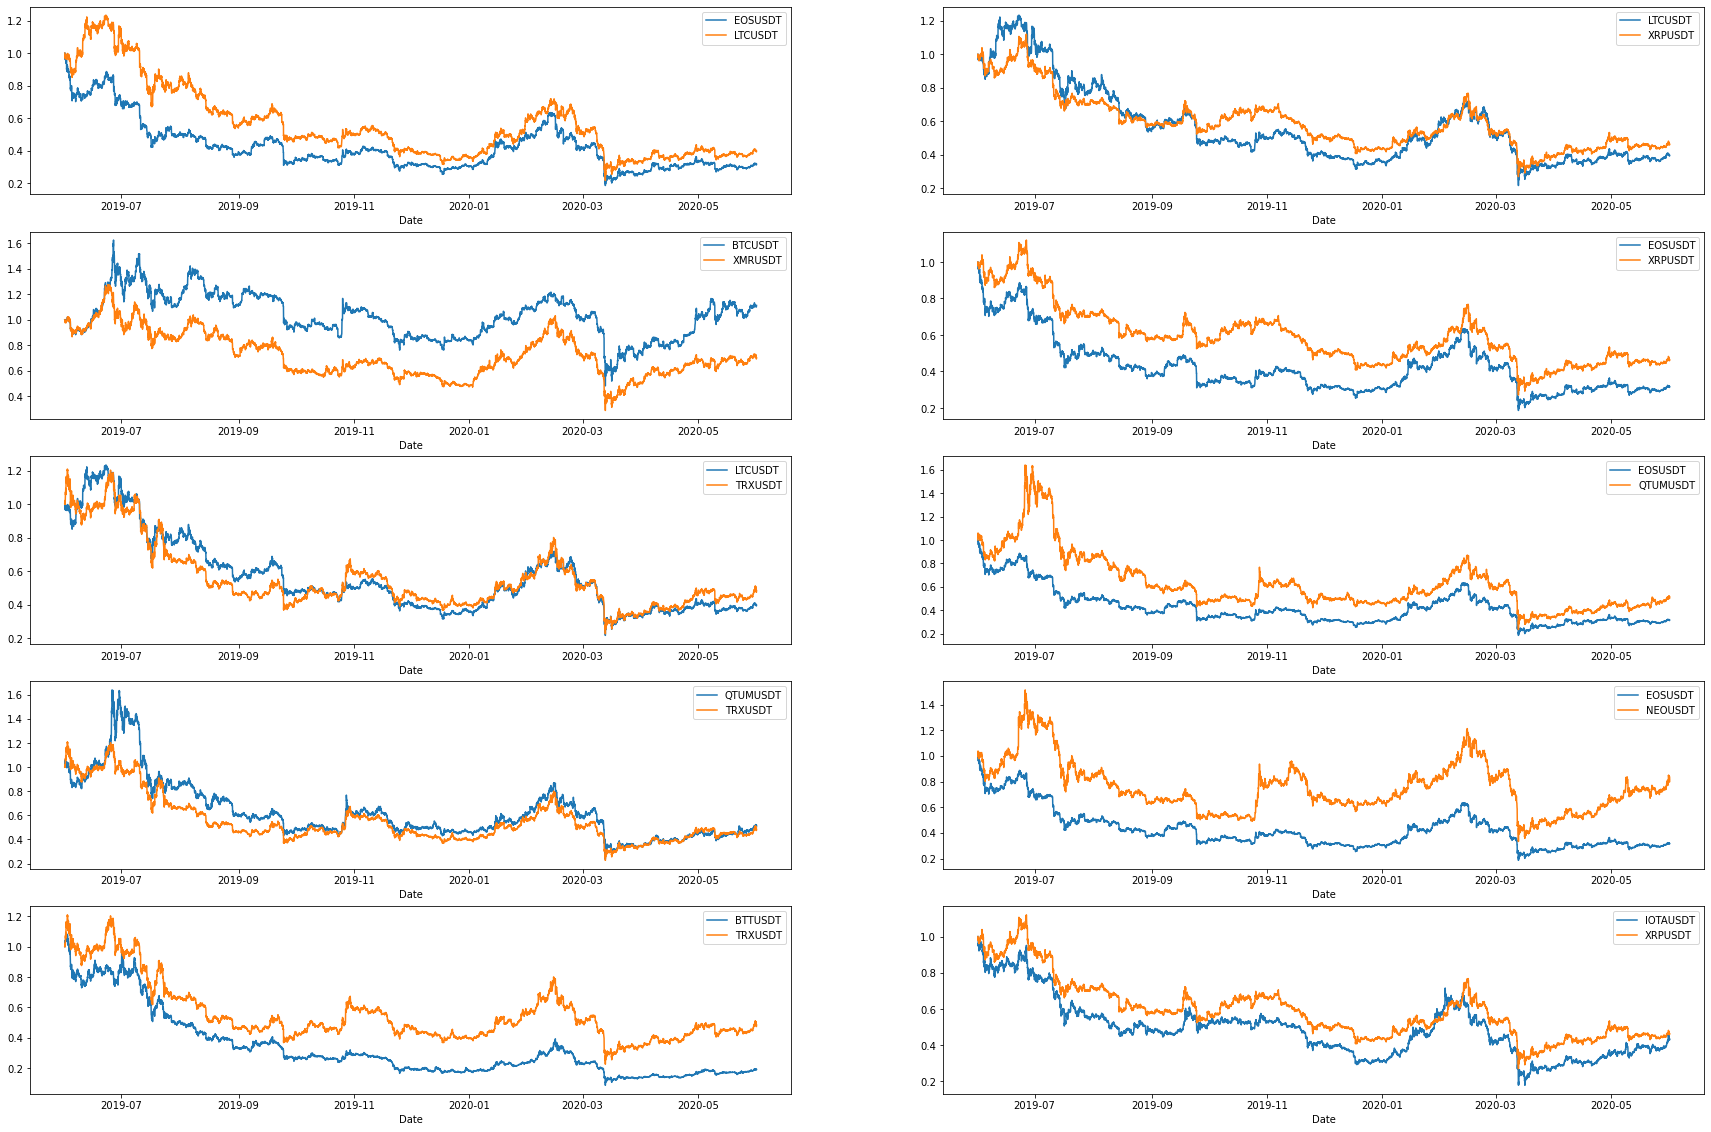

(datetime.datetime(2019, 9, 1, 0, 0), datetime.datetime(2020, 9, 1, 1, 0))


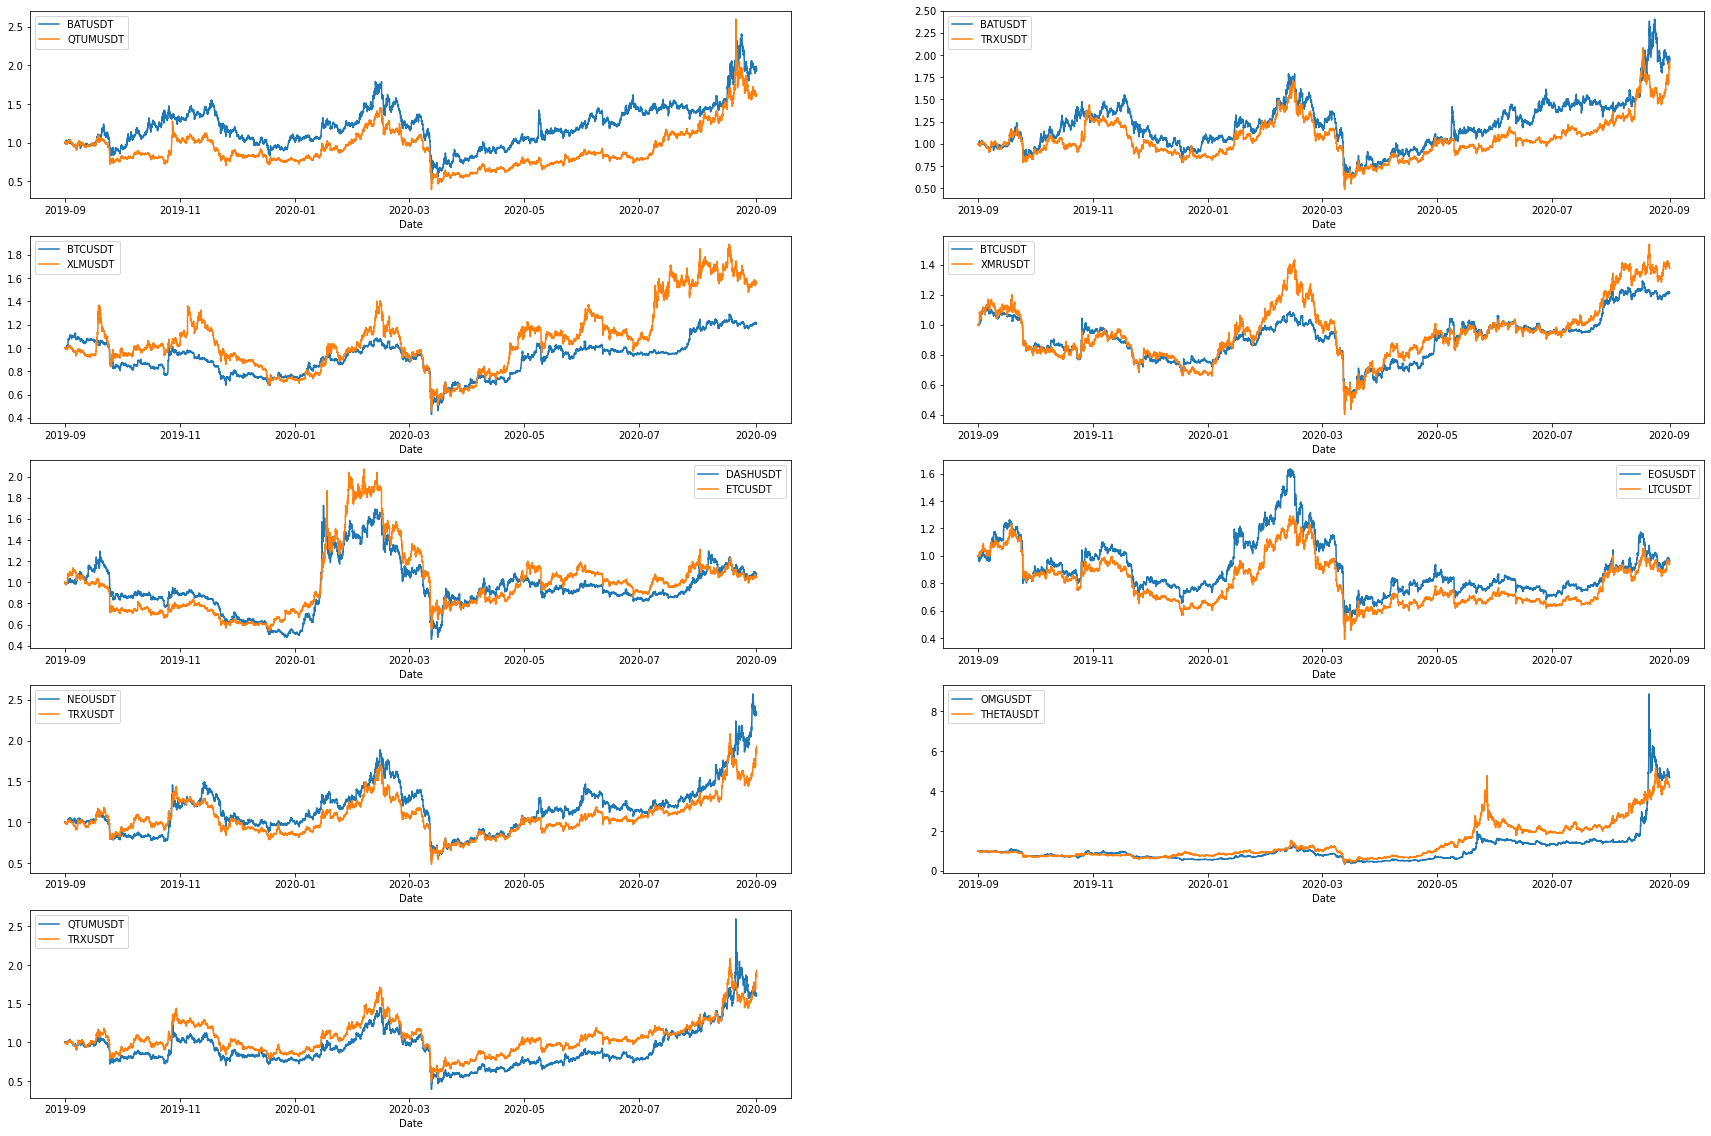

(datetime.datetime(2019, 12, 1, 0, 0), datetime.datetime(2020, 12, 1, 1, 0))


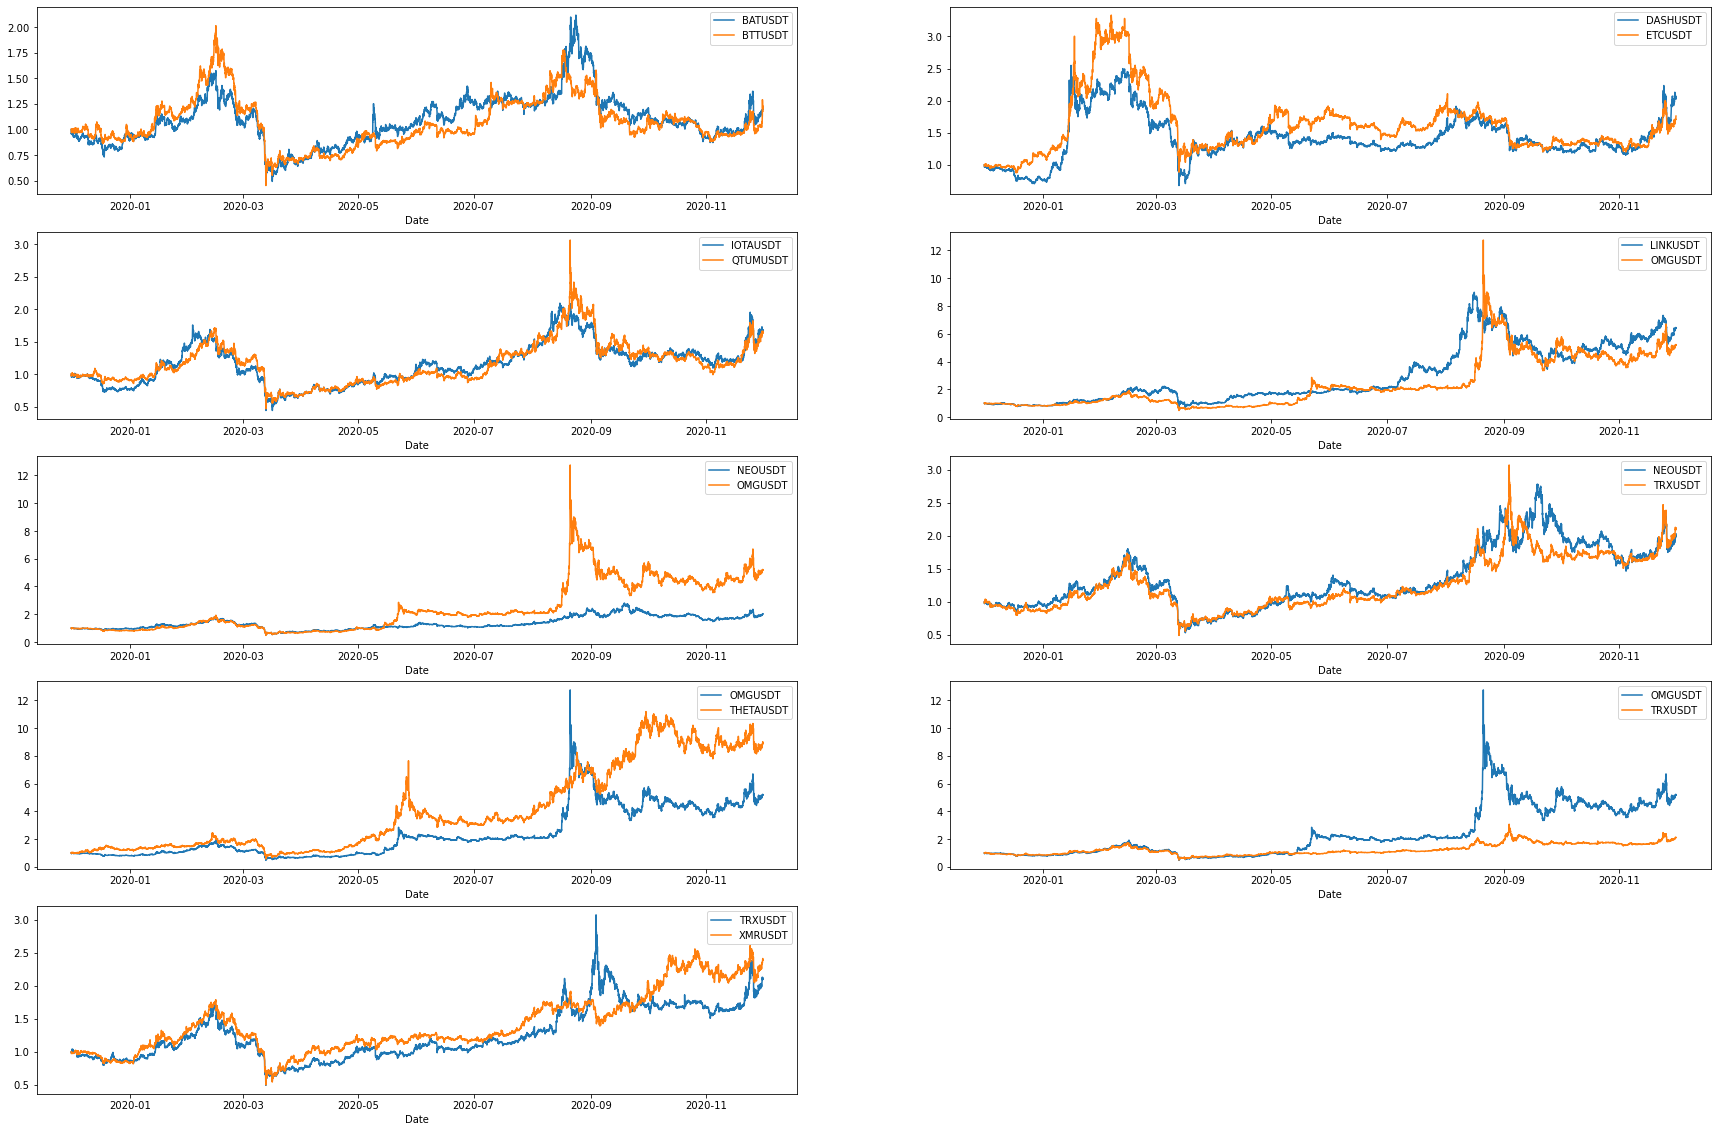

(datetime.datetime(2020, 3, 1, 0, 0), datetime.datetime(2021, 3, 1, 1, 0))


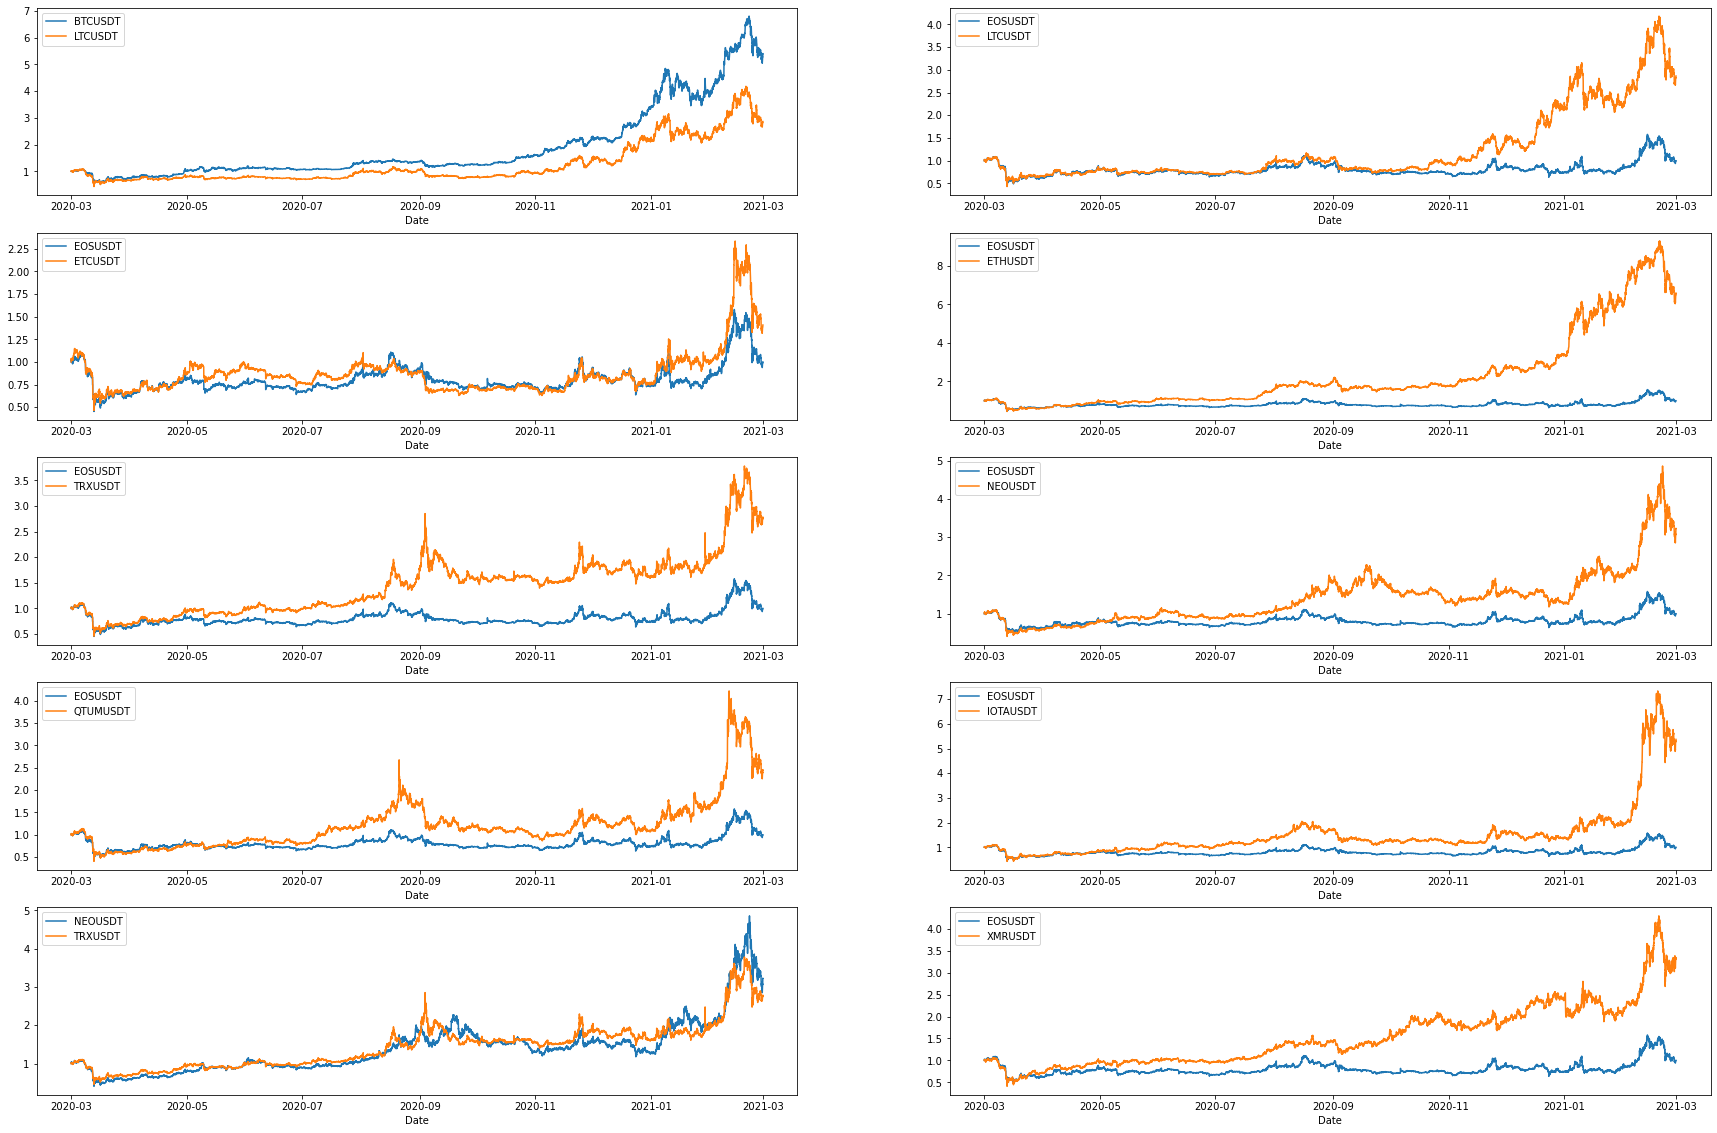

In [87]:
for ix in range(len(train_in)):
    print(train_in[ix])
    dtr_l = dt_dict[ix]['dtr_l']
    dtr_s = dt_dict[ix]['dtr_s']
    drtr_l = dt_dict[ix]['drtr_l']
    drtr_s = dt_dict[ix]['drtr_s'] 
    
    pairs = [(dtr_l.columns[x],dtr_s.columns[x]) for x in range(len(dtr_l.columns))]
    plt.figure(figsize = (30,20))
    for i in range(len(pairs)):
        plt.subplot(5,2,i+1)
        plt.plot(dtr_l.iloc[:,i].divide(dtr_l.iloc[0,i]), label = pairs[i][0])
        plt.plot(dtr_s.iloc[:,i].divide(dtr_s.iloc[0,i]), label = pairs[i][1])
        plt.xlabel("Date")
        plt.legend()
    plt.show()


In [88]:
# # Mean-reversion effect analysis

# thres = 2
# cl = 0.5

# for win in [168,240,360,480,720,1440]:
#     print("------------------ Rolling window: %s ---------------------------------------------------" % win)
#     stats_mean = []
#     for ix in range(len(train_in)):
#         dt_period = dt_dict[ix]
#         spread = dt_period['test_spread']
#         print("Test period: %s" % str(test_periods[ix]))
#         print("Length of test period: %s" % len(spread))
# #         print(z_score.columns)
        
#         z_score = (spread - spread.rolling(win).mean()) / spread.rolling(win).std()
        
#         stats = pd.DataFrame(columns = range(len(z_score.columns)), index = ['count_open','len_mean','len_std','len_max','len_min'])
        
#         for col in range(len(z_score.columns)):
#             OPEN = False
#             count_open = 0
#             count_len = []
#             ix_open = 0
#             for d in range(1,len(z_score)):
#                 if z_score.iloc[d,col] > thres and z_score.iloc[d-1,col] < thres and not OPEN: 
#                     count_open += 1
#                     ix_open = d
#                     OPEN = True
#                 elif z_score.iloc[d,col] < -thres and z_score.iloc[d-1,col] > -thres and not OPEN:
#                     count_open += 1
#                     ix_open = d
#                     OPEN = True
#                 elif z_score.iloc[d,col] < cl and z_score.iloc[d-1,col] > cl and OPEN:
#                     count_len.append(d-ix_open)
#                     OPEN = False
#                 elif z_score.iloc[d,col] > -cl and z_score.iloc[d-1,col] < -cl and OPEN:
#                     count_len.append(d-ix_open)
#                     OPEN = False
#                 else:
#                     continue
#             if (len(count_len) != 0):
#                 stats.iloc[0,col] = count_open
#                 stats.iloc[1,col] = np.round(np.mean(count_len),1)
#                 stats.iloc[2,col] = np.round(np.std(count_len),1)
#                 stats.iloc[3,col] = np.round(np.max(count_len),1)
#                 stats.iloc[4,col] = np.round(np.min(count_len),1)
# #         print(stats)
#         stats_mean.append(stats.mean(axis=1))    

#         plt.figure(figsize = (15,6))
#         plt.plot(z_score)
#         plt.fill_between(z_score.index,-2,2,facecolor='green', alpha=0.3)
#         plt.legend(z_score.columns, loc='best')
#         plt.xticks(rotation = 45)
#         plt.grid(True)
#         plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#         plt.show()
#         print("----------------------------------------------------------------------------------------")
#     allstats = pd.concat(stats_mean, axis=1)
#     print(allstats.mean(axis=1))

Notes:

Problems identified:
One. Most pairs' cointegration effects of period 3 and 4 not significant (false signal issue) -> increase cointegration test confidence level;

Two. Mean reversion time (oeriod 1,2,5 short, period 3,4 long);

Three. Stop loss threshold?

we decided to take a more techincal approach to the calculation of the spread, Z-score for the spread and then Rolling Spread z-score.


$$
S_{t} = y_{t} - \beta\ x_{t}
$$

$$
S_{t} = spread\ at\ time\ t
$$

$$
y_{t} = long\ price\ at\ time\ t
$$

$$
\beta = zero\ intercept\ linear\ regression\ coefficient\ at\ time\ t\ also\ known\ as\ the\ hedge\
$$

$$
x_{t} = short\ price\ at\ time\ t\ 
$$



$$
{Z\left( S \right)}_{t} = \frac{S_{t} - \text{μS}_{t}}{\sigma S_{t}}
$$


$$
{Z\left( S \right)}_{t} = Z - score\ of\ the\ spread\ in\ time\ 
$$

$$
S_{t} = spread\ in\ time\ 
$$

$$
\text{μS}_{t} = mean\ of\ the\ spread\ in\ time\ 
$$

$$
\sigma S_{t} = standard\ deviation\ of\ the\ Spread\ in\ time\ 
$$



In [89]:
# proposed strategy (base)
def signal(trspread, tsspread, window=168, uenter=2, lenter=-2, uexit=0.5, lexit=-0.5):
    
    """
    sig = (z - z_rollmean)/z_rollstd
    ---------------------------------
    uenter, lenter: enter threshold
    uexit, lexit: exit threshold
    """
    spread = pd.concat([trspread.iloc[-window:,:], tsspread],axis=0)
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
#     for win in range(72, window):
#         spread_mean.iloc[win,:] = spread.iloc[:win,:].mean()
#         spread_std.iloc[win,:] = spread.iloc[:win,:].std()
    z_score = (spread - spread_mean) / spread_std
    z_score = z_score.rolling(window = 5).mean()
    signals = z_score.copy().fillna(0)
    
    OPEN = False
    for i in range(1,z_score.shape[0]):
        for j in range(z_score.shape[1]):
            if pd.isna(z_score.iloc[i,j]): continue
            elif (z_score.iloc[i,j] <lenter) and (z_score.iloc[i-1,j] > lenter) and not OPEN: 
                signals.iloc[i,j] = 2 # undervalue - open long - buy l sell s
                OPEN = True
            elif (z_score.iloc[i,j] > uenter) and (z_score.iloc[i-1,j] < uenter) and not OPEN: 
                signals.iloc[i,j] = -2 # overvalue - open short - sell l buy s
                OPEN = True
            elif (z_score.iloc[i,j] < uexit) and (z_score.iloc[i-1,j] > uexit) and OPEN: 
                OPEN = False # close short - sell l buy s
                signals.iloc[i,j] = 3
            elif (z_score.iloc[i,j] > lexit) and (z_score.iloc[i-1,j] < lexit) and OPEN: 
                OPEN = False # close long - sell l buy s
                signals.iloc[i,j] = -3
            else:
                if OPEN:
                    signals.iloc[i,j] = 1 if signals.iloc[i-1,j] > 0 else -1
                else:
                    signals.iloc[i,j] = 0
#     signals_bt = signals.copy()
#     signals_bt = signals_bt.applymap(lambda x: )
    return signals
        

def cost(signals, cost, beta):
    
    """Transaction cost based on signal"""
    
    def costmap(x,beta):
        if abs(x) == 2:
            return (1+beta)*np.log(1/(1+cost))
        elif abs(x) == 3:
            return (1+beta)*np.log(1-cost)
        else:
            return 0
    ret_cost = signals.copy()
    for pair in range(len(beta.index)):
        b = beta[pair]
        ret_cost.iloc[:,pair] = signals.iloc[:,pair].map(lambda x: costmap(x,b))

    return ret_cost


def btest(dr_l, dr_s, signals, ret_cost, beta):
        
    pf_ret = pd.DataFrame(index=dr_l.index, columns = beta.index).fillna(0)
    for pair in range(len(beta.index)):
        for ix in range(len(pf_ret)):
            if signals.iloc[ix,pair] == 2:
                pf_ret.iloc[ix,pair] = ret_cost.iloc[ix,pair]
            elif signals.iloc[ix,pair] == -2:
                pf_ret.iloc[ix,pair] = ret_cost.iloc[ix,pair]
            elif signals.iloc[ix,pair] == -3:
                pf_ret.iloc[ix,pair] = dr_l.iloc[ix,pair] - beta[pair]*dr_s.iloc[ix,pair] + ret_cost.iloc[ix,pair]
            elif signals.iloc[ix,pair] == 3:
                pf_ret.iloc[ix,pair] = - dr_l.iloc[ix,pair] + beta[pair]*dr_s.iloc[ix,pair] + ret_cost.iloc[ix,pair]
            elif signals.iloc[ix,pair] == 1:
                pf_ret.iloc[ix,pair] = dr_l.iloc[ix,pair] - beta[pair]*dr_s.iloc[ix,pair]
            elif signals.iloc[ix,pair] == -1:
                pf_ret.iloc[ix,pair] = - dr_l.iloc[ix,pair] + beta[pair]*dr_s.iloc[ix,pair]
            else: # sinalsg.iloc[ix,pair] == 0
                pf_ret.iloc[ix,pair] = 0
                
        # close position on last day of test period 
        if abs(signals.iloc[-1,pair]) == 3:
            continue
        else:
            pf_ret.iloc[-1,pair] = 0

    return pf_ret

0
Time
2020-06-01 00:00:00    1.000000
2020-06-01 01:00:00    1.000000
2020-06-01 02:00:00    1.000000
2020-06-01 03:00:00    1.000000
2020-06-01 04:00:00    1.000000
                         ...   
2020-08-31 20:00:00    0.914006
2020-08-31 21:00:00    0.917445
2020-08-31 22:00:00    0.914772
2020-08-31 23:00:00    0.917526
2020-09-01 00:00:00    0.917526
Freq: 60T, Length: 2209, dtype: float64


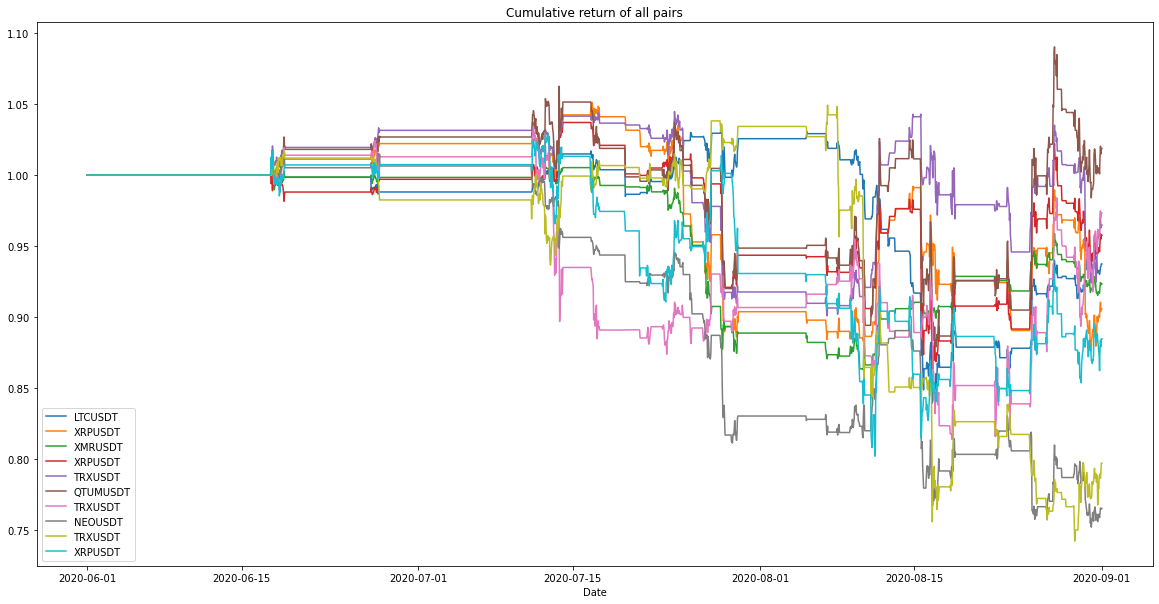

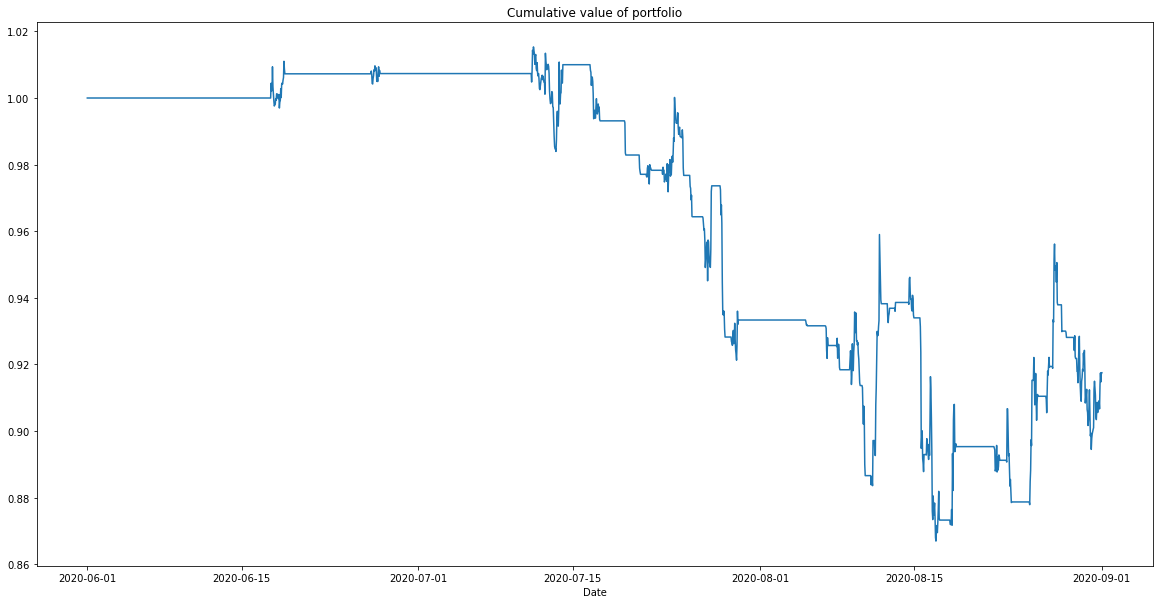

1
Time
2020-09-01 00:00:00    1.00000
2020-09-01 01:00:00    1.00000
2020-09-01 02:00:00    1.00000
2020-09-01 03:00:00    1.00000
2020-09-01 04:00:00    1.00000
                        ...   
2020-11-30 20:00:00    0.86323
2020-11-30 21:00:00    0.86323
2020-11-30 22:00:00    0.86323
2020-11-30 23:00:00    0.86323
2020-12-01 00:00:00    0.86323
Freq: 60T, Length: 2185, dtype: float64


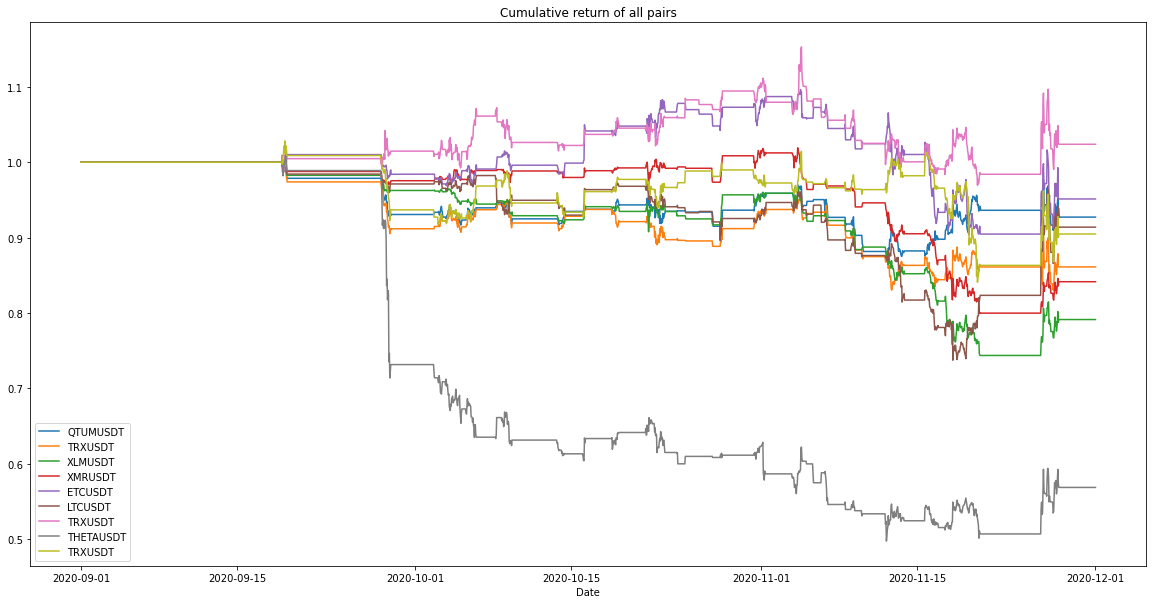

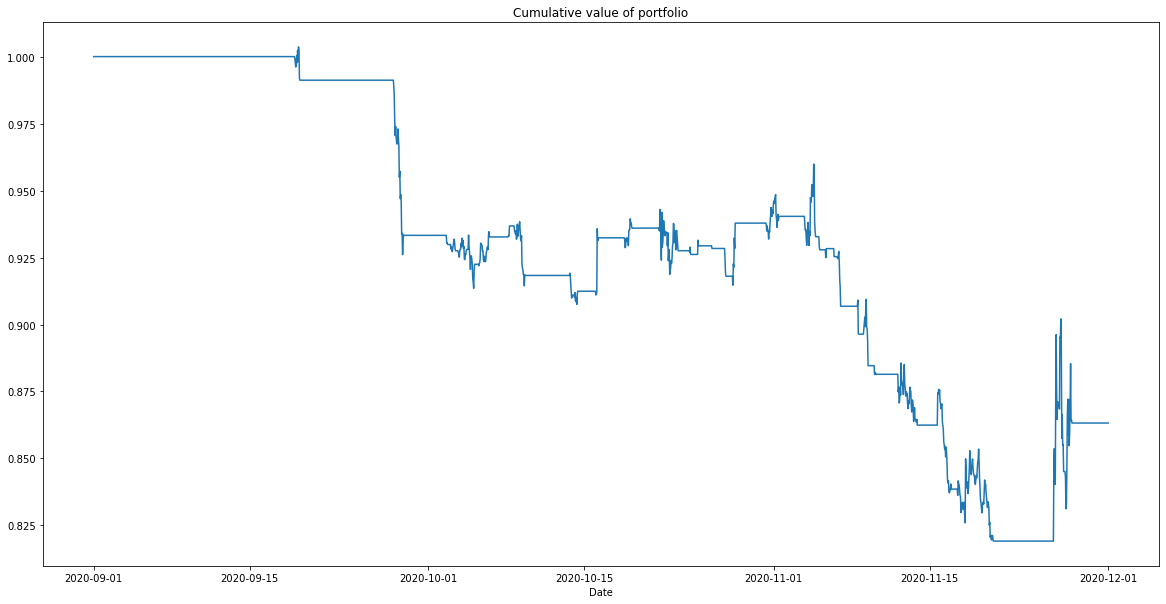

2
Time
2020-12-01 00:00:00    1.000000
2020-12-01 01:00:00    1.000000
2020-12-01 02:00:00    1.000000
2020-12-01 03:00:00    1.000000
2020-12-01 04:00:00    1.000000
                         ...   
2021-02-28 20:00:00    1.080915
2021-02-28 21:00:00    1.070307
2021-02-28 22:00:00    1.068086
2021-02-28 23:00:00    1.060664
2021-03-01 00:00:00    1.060664
Freq: 60T, Length: 2161, dtype: float64


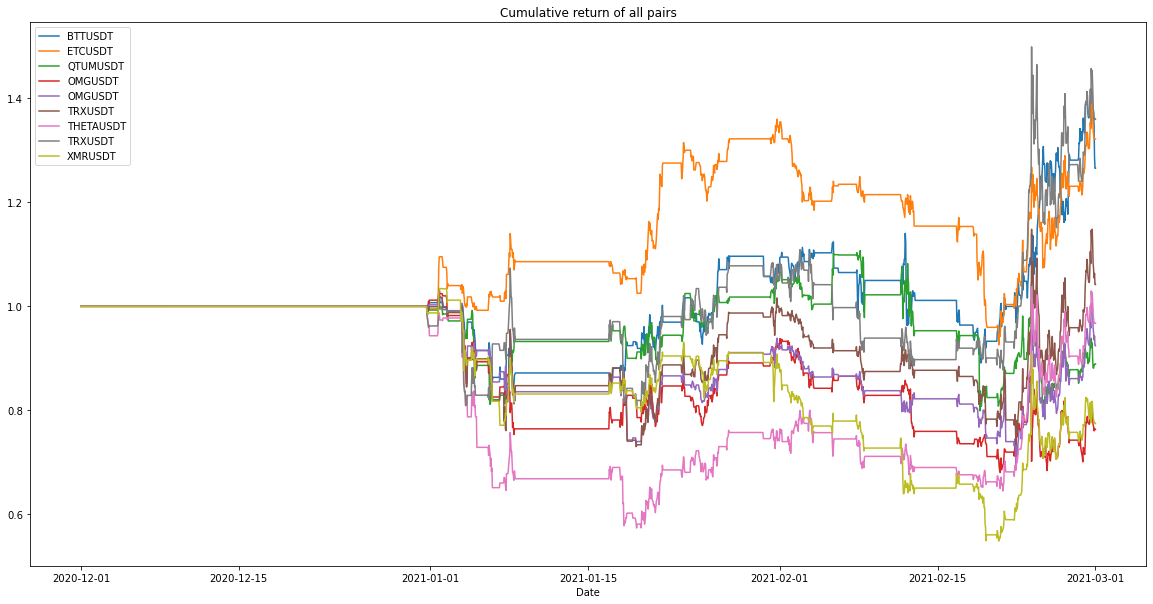

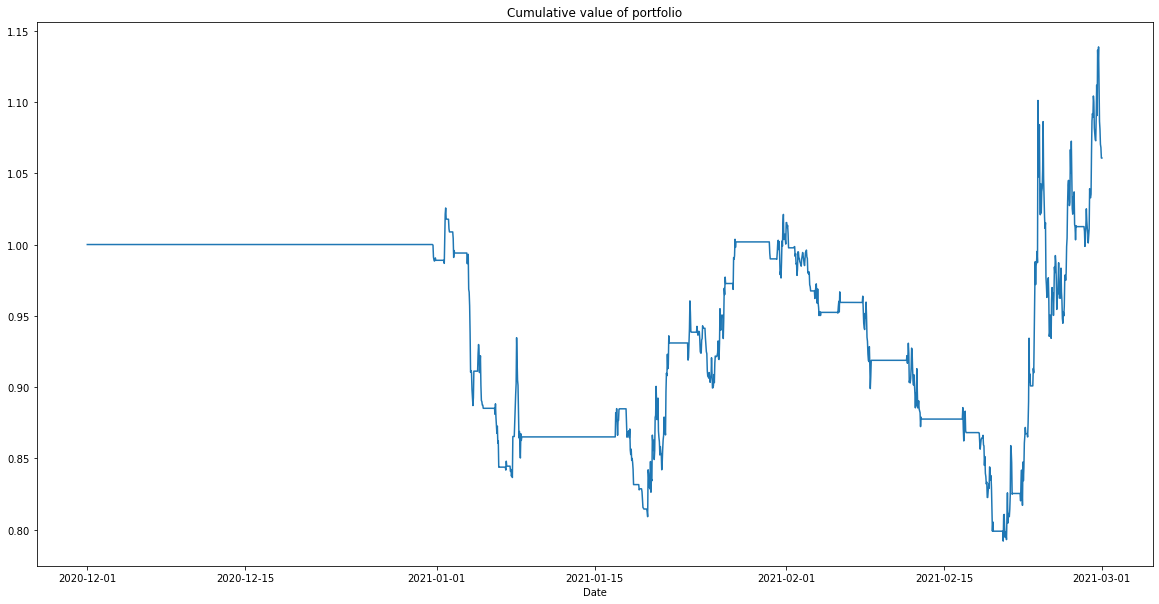

3
Time
2021-03-01 00:00:00    1.000000
2021-03-01 01:00:00    1.000000
2021-03-01 02:00:00    1.000000
2021-03-01 03:00:00    1.000000
2021-03-01 04:00:00    1.000000
                         ...   
2021-05-31 20:00:00    1.391832
2021-05-31 21:00:00    1.391832
2021-05-31 22:00:00    1.391832
2021-05-31 23:00:00    1.391832
2021-06-01 00:00:00    1.391832
Freq: 60T, Length: 2209, dtype: float64


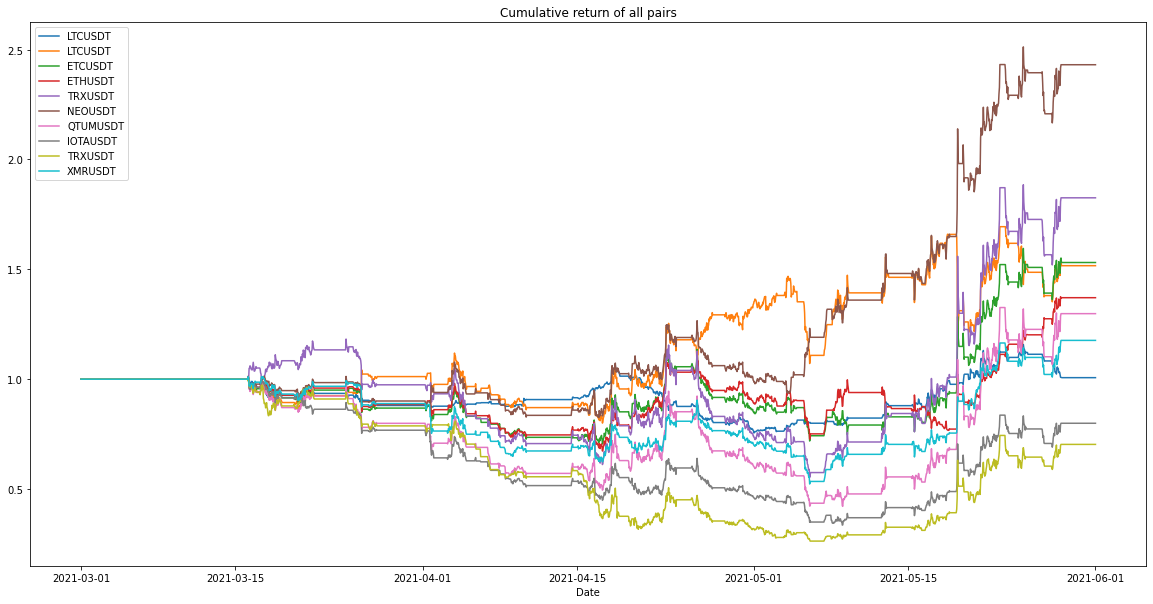

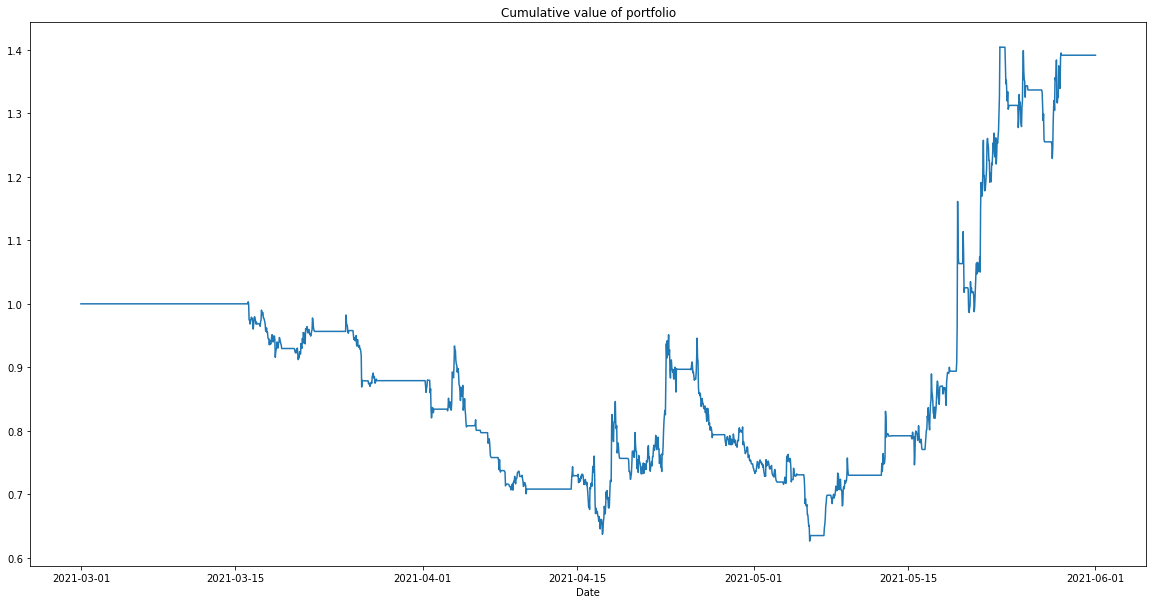

In [90]:
# Set up portfolio and backtest return

# notional = 1e6
# weight = 1/n_pairs
window = 360

signals_all = {}
costs_all = {}
pf_ret_all = {}
pf_cumret_all = {}
pf_wret_all = []

for ix in range(len(test_in)):
    print(ix)
    dtr_l = dt_dict[ix]['dtr_l']
    dtr_s = dt_dict[ix]['dtr_s']
    drtr_l = dt_dict[ix]['drtr_l']
    drtr_s = dt_dict[ix]['drtr_s'] 
    
    dts_l = dt_dict[ix]['dts_l']
    dts_s = dt_dict[ix]['dts_s']
    drts_l = dt_dict[ix]['drts_l']
    drts_s = dt_dict[ix]['drts_s'] 
    beta = rg.OLS(np.log(dtr_l), np.log(dtr_s)).fit().params[0]
    train_spread = dt_dict[ix]['train_spread']
    test_spread = dt_dict[ix]['test_spread']
    pairs = [x for x in beta.index]
    
    # first check spread adf test
    
    signals = signal(train_spread, test_spread, window=window)
    pct_costs = cost(signals, 6e-3, beta)
    signals_all[ix] = signals
    costs_all[ix] = pct_costs
    
#     # portfolio
#     pf = pd.DataFrame(index=dts_l.index, columns=pairs)
#     pf = pf.fillna(notional*weight)
    
    pf_ret = btest(drts_l, drts_s, signals, pct_costs, beta)
    pf_wret = pf_ret.sum(axis=1) / len(beta)
    
    pf_cum_ret = (1 + pf_ret).cumprod()
    pf_cum_wret = (1 + pf_wret).cumprod()
    print(pf_cum_wret)
    
    plt.plot(pf_cum_ret)
    plt.xlabel('Date')
    plt.title("Cumulative return of all pairs")
    plt.legend(pairs)
    plt.show()
    
    plt.plot(pf_cum_wret)
    plt.xlabel('Date')
    plt.title("Cumulative value of portfolio")
    plt.show()
    
    pf_ret_all[ix] = pf_ret
    pf_cumret_all[ix] = pf_cum_ret
    pf_wret_all.append(pf_wret)
    
pf_wret_merge = pd.concat(pf_wret_all, axis=0)
pf_cumwret_merge = (1 + pf_wret_merge).cumprod()
 

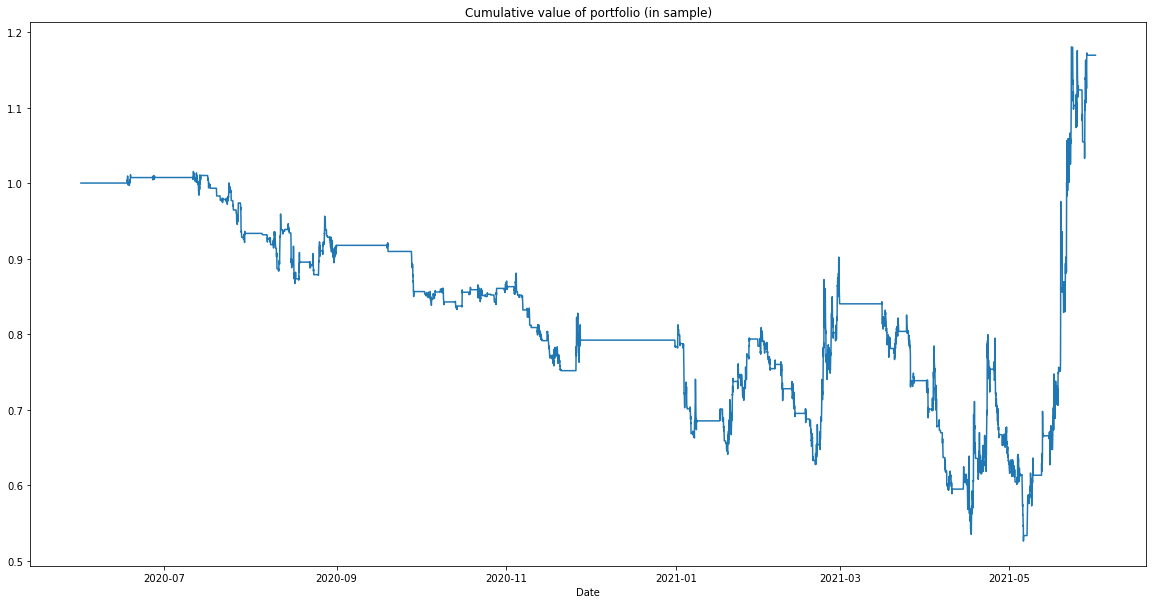

In [91]:
plt.plot(pf_cumwret_merge)
plt.xlabel('Date')
plt.title("Cumulative value of portfolio (in sample)")
plt.show()

In [92]:
SR = (pf_cumwret_merge[-1]-1)**(8760/len(pf_cumwret_merge)) / ((pf_wret_merge.std())*np.sqrt(8760))
SR

0.2566803073107896

## out of sample test

4
Time
2021-06-01 00:00:00    1.000000
2021-06-01 01:00:00    1.000000
2021-06-01 02:00:00    1.000000
2021-06-01 03:00:00    1.000000
2021-06-01 04:00:00    1.000000
                         ...   
2021-08-31 20:00:00    0.738700
2021-08-31 21:00:00    0.739806
2021-08-31 22:00:00    0.737893
2021-08-31 23:00:00    0.733413
2021-09-01 00:00:00    0.733413
Freq: 60T, Length: 2209, dtype: float64


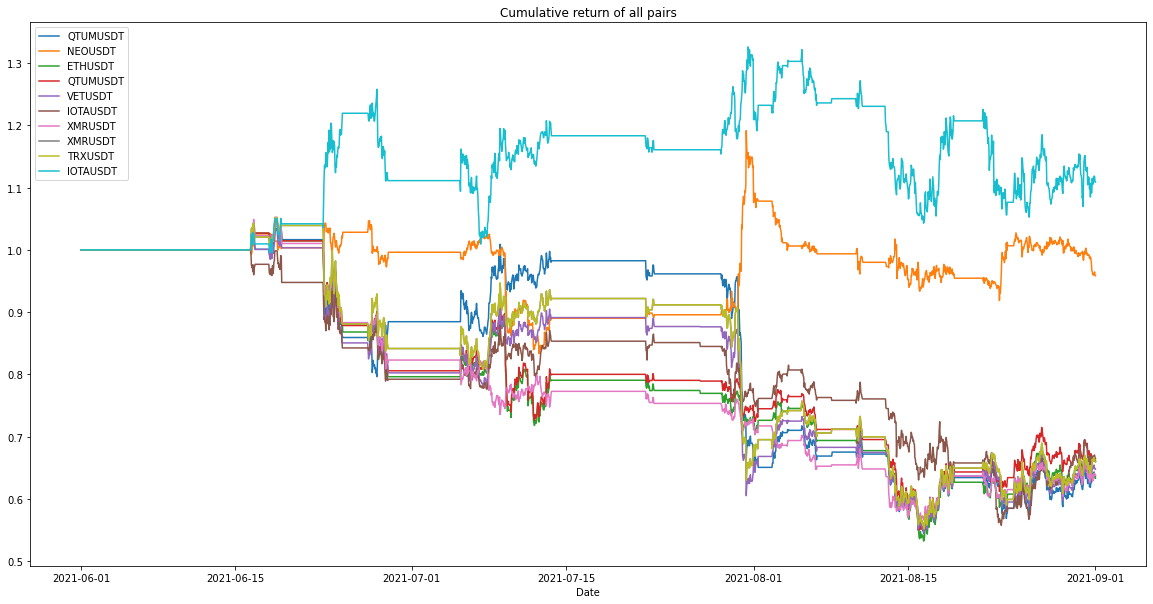

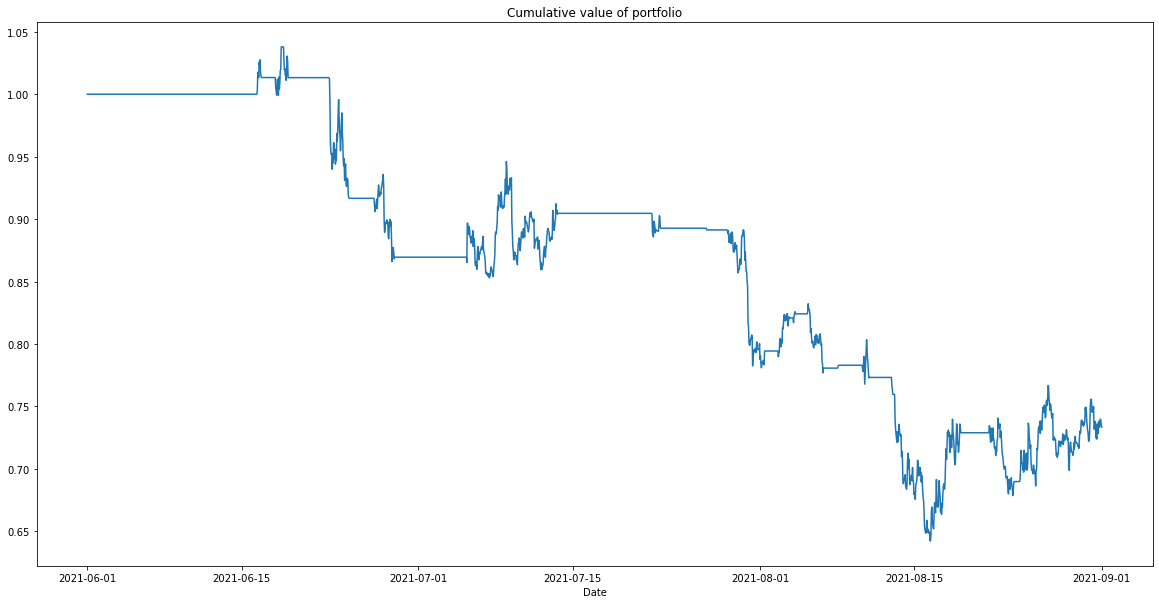

5
Time
2021-09-01 00:00:00    1.000000
2021-09-01 01:00:00    1.000000
2021-09-01 02:00:00    1.000000
2021-09-01 03:00:00    1.000000
2021-09-01 04:00:00    1.000000
                         ...   
2021-11-30 19:00:00    1.233311
2021-11-30 20:00:00    1.233311
2021-11-30 21:00:00    1.233311
2021-11-30 22:00:00    1.233311
2021-11-30 23:00:00    1.233311
Freq: 60T, Length: 2184, dtype: float64


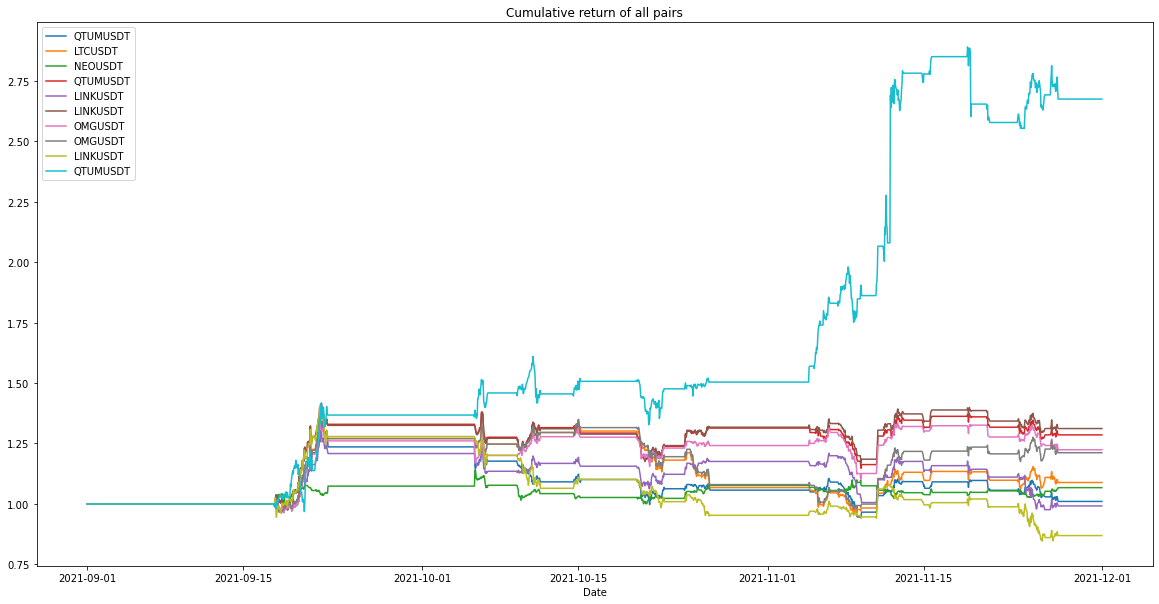

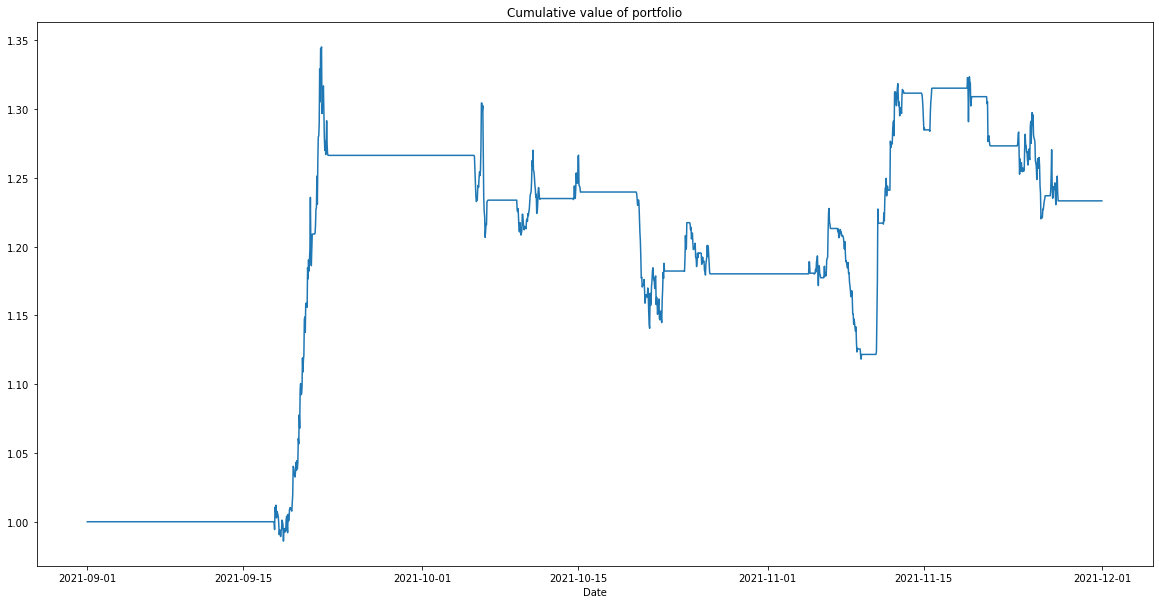

In [93]:
# Set up portfolio and backtest return

# notional = 1e6
# weight = 1/n_pairs
window = 360

oos_signals_all = {}
oos_costs_all = {}
oos_ret_all = {}
oos_cumret_all = {}
oos_wret_all = []

for ix in range(4,4+len(test_oos)):
    print(ix)
    dtr_l = dt_dict[ix]['dtr_l']
    dtr_s = dt_dict[ix]['dtr_s']
    drtr_l = dt_dict[ix]['drtr_l']
    drtr_s = dt_dict[ix]['drtr_s'] 
    
    dts_l = dt_dict[ix]['dts_l']
    dts_s = dt_dict[ix]['dts_s']
    drts_l = dt_dict[ix]['drts_l']
    drts_s = dt_dict[ix]['drts_s'] 
    beta = rg.OLS(np.log(dtr_l), np.log(dtr_s)).fit().params[0]
    train_spread = dt_dict[ix]['train_spread']
    test_spread = dt_dict[ix]['test_spread']
    pairs = [x for x in beta.index]
    
    # first check spread adf test
    
    signals = signal(train_spread, test_spread, window=window)
    pct_costs = cost(signals, 6e-3, beta)
    oos_signals_all[ix] = signals
    oos_costs_all[ix] = pct_costs
    
#     # portfolio
#     pf = pd.DataFrame(index=dts_l.index, columns=pairs)
#     pf = pf.fillna(notional*weight)
    
    oos_ret = btest(drts_l, drts_s, signals, pct_costs, beta)
    oos_wret = oos_ret.sum(axis=1) / len(beta)
    
    oos_cum_ret = (1 + oos_ret).cumprod()
    oos_cum_wret = (1 + oos_wret).cumprod()
    print(oos_cum_wret)
    
    plt.plot(oos_cum_ret)
    plt.xlabel('Date')
    plt.title("Cumulative return of all pairs")
    plt.legend(pairs)
    plt.show()
    
    plt.plot(oos_cum_wret)
    plt.xlabel('Date')
    plt.title("Cumulative value of portfolio")
    plt.show()
    
    oos_ret_all[ix] = oos_ret
    oos_cumret_all[ix] = oos_cum_ret
    oos_wret_all.append(oos_wret)
    
oos_wret_merge = pd.concat(oos_wret_all, axis=0)
oos_cumwret_merge = (1 + oos_wret_merge).cumprod()
 

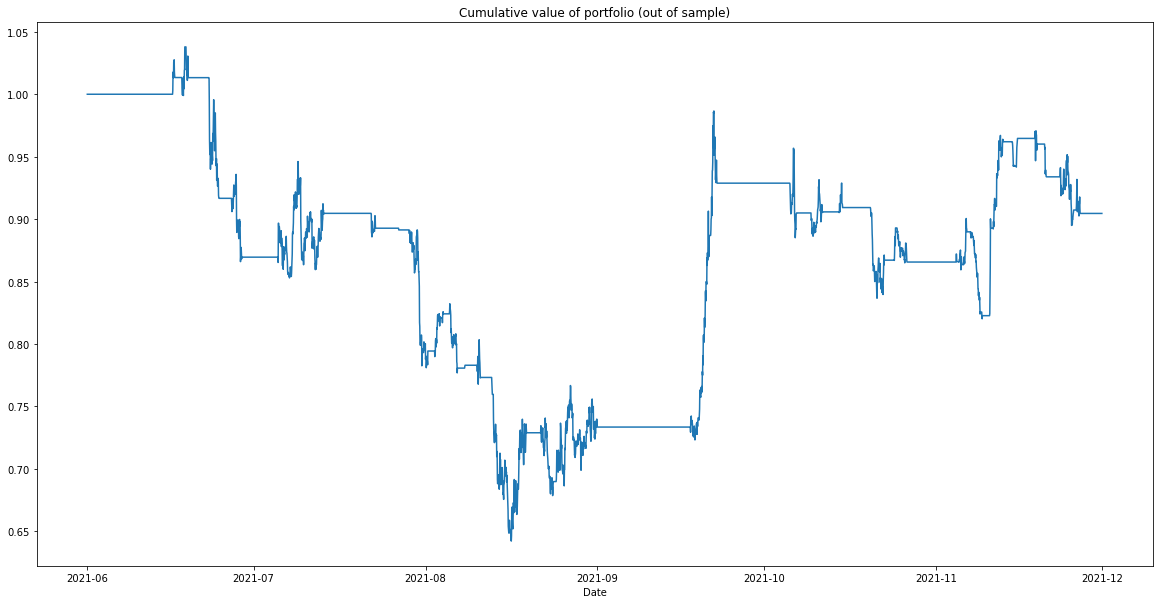

In [94]:
plt.plot(oos_cumwret_merge)
plt.xlabel('Date')
plt.title("Cumulative value of portfolio (out of sample)")
plt.show()

In [95]:
SR = (oos_cumwret_merge[-1]-1)**(8760/len(oos_cumwret_merge)) / ((oos_wret_merge.std())*np.sqrt(8760))
SR

nan

## Combined performance of in and out sample periods

0.2493110767167804


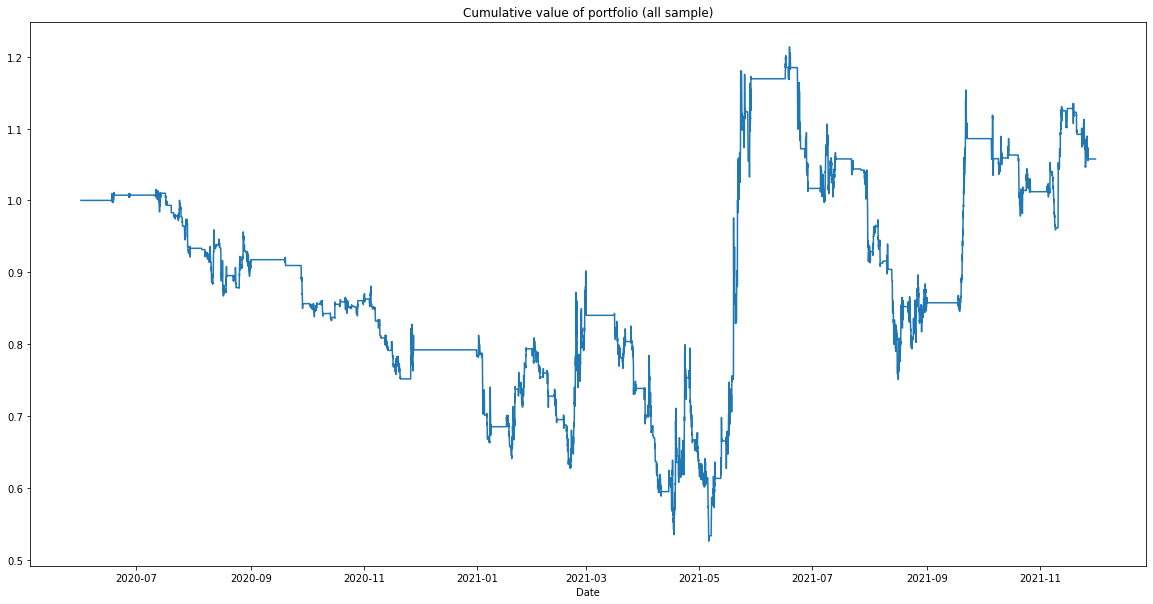

In [96]:
all_wret_merge = pd.concat([pf_wret_merge, oos_wret_merge])
all_cumwret_merge = (1 + all_wret_merge).cumprod()
SR = (all_cumwret_merge[-1]-1)**(8760/len(all_cumwret_merge)) / ((all_wret_merge.std())*np.sqrt(8760))
print(SR)

plt.plot(all_cumwret_merge)
plt.xlabel('Date')
plt.title("Cumulative value of portfolio (all sample)")
plt.show()